# Week 9: Support Vector Machines

Up to now, we have approached classification using "generative" models. That is models that generate predicted probabilites and use these to come up with labels for new observations. An example of this would be logistic regression where our predicted probability is of the form:

$$ \pi(X) = \frac{1}{1 + e^{-\beta_0 - \beta_1 X_1 - ... - \beta_p X_p}}$$

we then use our training data to "learn" the parameters $\beta_0, ..., \beta_p$ by minimizing some cost function.

In contrast, a discriminative model will simply attempt to draw a line through the two classes, and decide which class the new observation is by which side of the line it falls on.

*The material below draws heavily from examples in the Python Data Science Handbook by*


In [33]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

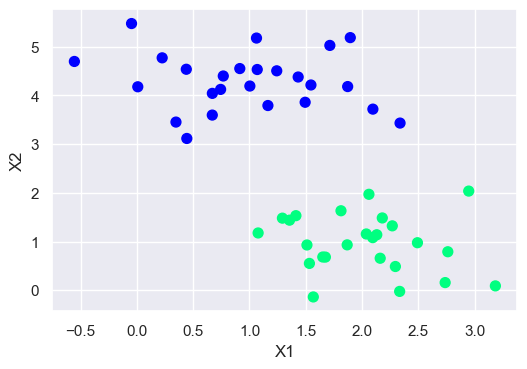

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets.samples_generator import make_blobs 
X, y = make_blobs(n_samples=50, centers=2,
                             random_state=0, cluster_std=0.60)
plt.figure(figsize = (6,4))
plt.xlabel("X1")
plt.ylabel("X2")
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter');

In the example above, it is clear to see that drawing a line that seperates the two classes would be straightforward, we could do this by hand. However, if two people drew lines independently, it's unlikely that their two lines would agree. More broadly, the problem is that there are an infinite number of lines that we could draw to seperate these two classes. The question then becomes: which line to choose?

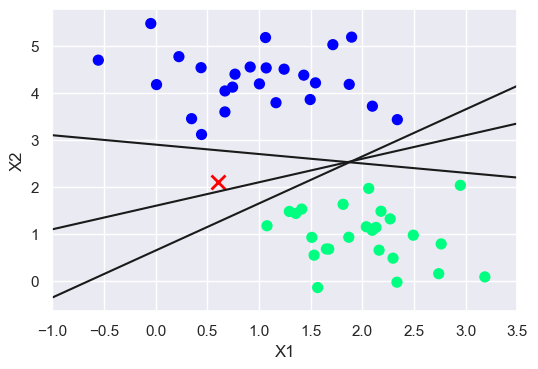

In [51]:
import numpy as np
xfit = np.linspace(-1, 3.5)
plt.figure(figsize = (6,4))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plt.xlabel("X1")
plt.ylabel("X2")
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]: 
    plt.plot(xfit, m * xfit + b, '-k')
    plt.xlim(-1, 3.5);

## Maximizing the Margin and Imperfect Classification

As we can see above, these three different lines give very different classification rules. Depending on the line that we choose the new observation (labeled as a red $X$) will be classified differently. Support vector machines solve this problem by choosing the "margin", or the distance between the line and the nearest point.

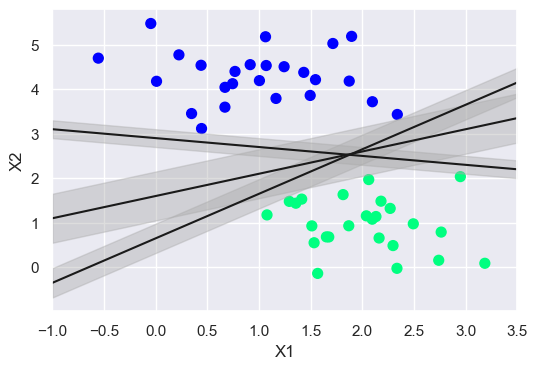

In [52]:
xfit = np.linspace(-1, 3.5)
plt.figure(figsize = (6,4))
plt.xlabel("X1")
plt.ylabel("X2")
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]: 
    yfit=m*xfit+b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha = 0.4)
    plt.xlim(-1, 3.5);

We can think of the problem of finding the optimal line as solving a maximization problem, something like:
\begin{align}
&\max \;\;\;\text{Margin between line and nearest point}\\
&\text{ subject to:}\;\;\;\text{ all points correctly classified}
\end{align}

This is all very well when our data is clean and classes are clearly seperated. However, what happens when we cannot perfectly linearly discriminate between the two classes? For example, what if our data looks like the following:

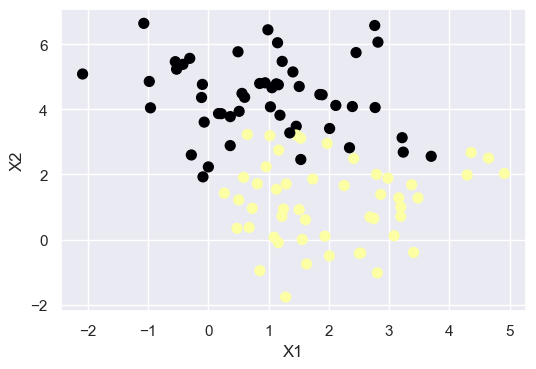

In [53]:
X, y = make_blobs(n_samples=100, centers=2,
                              random_state=0, cluster_std=1.2)
plt.figure(figsize = (6,4))
plt.xlabel("X1")
plt.ylabel("X2")
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='inferno');

We can clearly see now that there is no line that we can draw that will perfectly discriminate between the two classes. 

1. Add more features until we can perfectly discrimate between the classes. 

Note that, so long as we have at least one continuous feature, this will generally always be possible. However, in order to allow for a perfect linear discriminator, we may need to add almost as many features as there are data points. This will lead to an overly complex model that might not generalize very well.

2. Allow for imperfect discrimination

This is the approach that we will standardly take. The extent to which we allow for imperfect discrimination will be controlled by a tuning parameter $C$ that will have to be chosen by cross-fitting or some other method. We can think of the imperfectly discriminating SVM as solving:

\begin{align}
&\max \;\;\;\text{Margin between line and nearest external point} - C\cdot\text{# of points inside the margin}\\
&\text{ subject to:}\;\;\;\text{ all other external points correctly classified}
\end{align}

A small $C$ will allow for more points inside the margin but may lead to a potentially simpler model, whereas a larger value of $C$ will not allow as mony points in the margin, but may lead to a more complicated model to force the seperation.



## Fitting SVMs using Python

We will use sklearn to fit Support Vector Machines in Python. To illustrate we will use the 

In [70]:
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.datasets import load_breast_cancer
import pandas as pd
iris = sns.load_dataset('iris')
iris.head()


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


We will use sepal length, sepal width, petal length, and petal width to predict whether or not the flower is setosa. 

In [88]:
X = iris[['sepal_length', 'sepal_width','petal_length','petal_width']]
y = 1*(iris.species == "setosa")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)


We can plot this data to see how the classification varies by each of our characteristics 

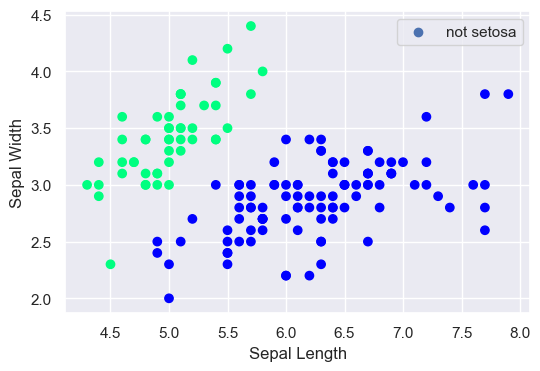

In [84]:
plt.scatter(iris.sepal_length, iris.sepal_width, c=y, cmap = "winter");
plt.xlabel("Sepal Length");
plt.ylabel("Sepal Width");
plt.legend(["not setosa"]);

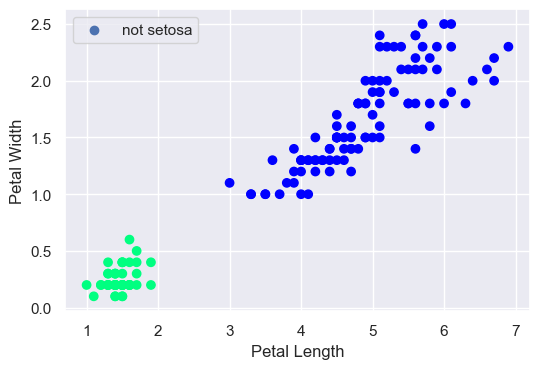

In [85]:
plt.scatter(iris.petal_length, iris.petal_width, c=y, cmap = "winter");
plt.xlabel("Petal Length");
plt.ylabel("Petal Width");
plt.legend(["not setosa"]);

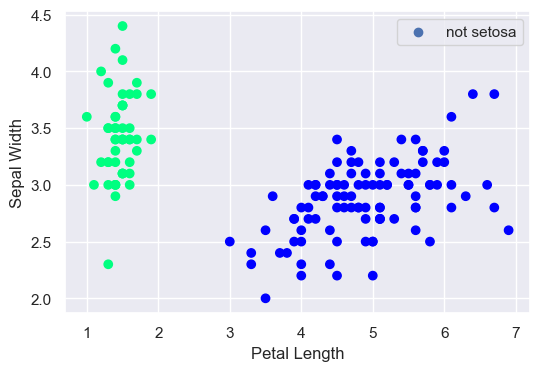

In [86]:
plt.scatter(iris.petal_length, iris.sepal_width, c=y, cmap = "winter");
plt.xlabel("Petal Length");
plt.ylabel("Sepal Width");
plt.legend(["not setosa"]);

We can see from thesae charts that a linear discriminatory model may do a good job as the two classes are well seperated. To fit the model we follow similar steps to before.

We first initialize the model using 

`` model = SVC(kernel='linear', C = some_number)``

Here it looks like we can well seperate the two classes so we will set C to be very large, in essence enforcing a "hard" SVM. We are also enforcing a linear kernel, which means that our final discriminatory line will be a straight line in $\mathbb{R}^4$. However, we could also use a "polynomial" or "Gaussian" kernel, which would allow for nonlinear discriminatory lines.

In [87]:
model = SVC(kernel='linear', C= 1E10)

Now that we have initialized the model, we can pass it our $X$ and $y$ data to fit the model (choose the discriminatory line). We do this using 

``model.fit(X_train,y_train)``

This initializes the "model" with some parameters that govern the shape of the line and sets the parameters to those that maximize the margin (or maximize the soft margin).

In [89]:
model.fit(X_train, y_train)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

We can now use this model to make predictions using 

`` model.predict(X_test)``

and assess the accuracy using these predictions


In [112]:
yHat = model.predict(X_test)
accuracy = np.mean(1*(yHat == y_test))
print(accuracy)

1.0


The SVM model is doing very well (perfect accuracy). This is consistent with the linear seperation we saw in the plots. Let's take a look at what the line looks like in 2 dimensions.

In [204]:
X_train_2D = X_train[['sepal_length', 'sepal_width']]
X_test_2D = X_test[['sepal_length', 'sepal_width']]
model_2D = SVC(kernel = 'linear', C = 1E10)
model_2D.fit(X_train_2D, y_train)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Now we can use this model to draw our classificaiton regions


In [205]:
h=
x_min, x_max = X_test_2D['sepal_length'].min() - 1, X_test_2D['sepal_length'].max() + 1
y_min, y_max = X_test_2D['sepal_width'].min() - 1, X_test_2D['sepal_width'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

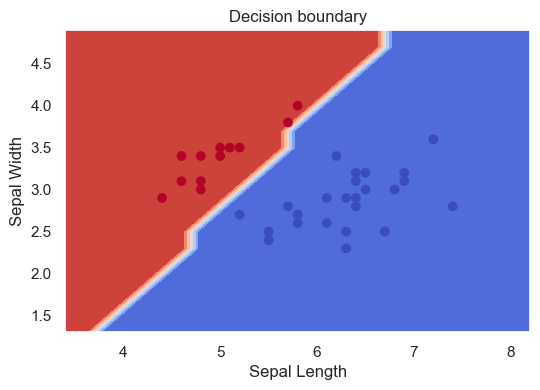

In [219]:
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=1)

# Plot also the training points
plt.scatter(X_test_2D['sepal_length'], X_test_2D['sepal_width'], c=y_test, cmap=plt.cm.coolwarm)
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())
plt.title("Decision boundary");
